# 1. The challenge

* The [`domain classification`](https://github.com/hellohaptik/haptik_open_datasets/tree/master/domain_classification) challenge from [Haptik Open Datasets](https://github.com/hellohaptik/haptik_open_datasets): Classify (short) user queries into one of the given nine classes.
* Expected Performance
    - Suggested metric: Overall Accuracy/Subset Accuracy
    - Baseline Performance: 70%
    - Expected Performance: >80%

**Some observations**:

1. Messages contain system specific content that needs to be removed.
2. (Overall) Subset Accuracy is `not appropriate` for this task, so we'll use label accuracy for model development.
    - For example, Subset Accuracy cannot distinguish between a model that gets 1 out of 3 positive labels wrong and a model that gets 2 out of 3 positive labels wrong (for a given document).

## 1.1. (Multi-class) Multi-label Classification

* **Multiclass classification** means a classification task with more than two classes
* **Multilabel classification** assigns to each sample a set of target labels
---
* Inherently multiclass: Naive Bayes, LDA and QDA, Decision Trees, Random Forests, Nearest Neighbors, setting multi_class='multinomial' in sklearn.linear_model.LogisticRegression.
* Support multilabel: Decision Trees, Random Forests, Nearest Neighbors.
---

* [One vs Rest (OvR) Classifiers](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) are the bread and butter of multi-class and multi-label classification. Scikit-learn lets us turn any binary classifier into a multi-class/multi-label classifier using the *One vs Rest* (OvR) scheme.
* We have to use [Multi-label Binarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) to get the data into the right format for training.
* Scikit-learn has [a page on Multiclass and multilabel algorithms](http://scikit-learn.org/stable/modules/multiclass.html).
* [scikit-multilearn](http://scikit.ml/) is a multi-label classification library for python, which you can check out if you are feeling adventurous.


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from haptik import *

mlb = MultiLabelBinarizer()
mlb.fit_transform([(1, 2), (3,)])

In [ ]:
mlb.classes_

In [ ]:
mlb.fit_transform([set(['sci-fi', 'thriller']), set(['comedy'])])

In [ ]:
mlb.classes_

# 2. The Codebase

We'll develop a class `Haptik` for organising our experiments.

## 2.1. Importing necessary modules and utility functions

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import time                                                
import pickle
import copy
import string
import operator
from collections import OrderedDict
from autocorrect import spell
from pprint import pprint
import re

import pandas as pd
import numpy as np

from nltk.tokenize import TreebankWordTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Decorators inside classes are not a good idea
# https://stackoverflow.com/questions/13852138/how-can-i-define-decorator-method-inside-class
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [ ]:
def pickle_dump(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

def pickle_load(filename):
    with open(filename, 'rb') as f:
        # https://stackoverflow.com/questions/28218466/unpickling-a-python-2-object-with-python-3
        return pickle.load(f)

## 2.2. `Haptik` Class: Constructor

**Note**:
* **multi_label_binarizer**: We don't need to use `MultiLabelBinarizer()` from scikit-learn for bringing the target vector (matrix) into the correct format since it's almost in the correct format already, so we write out own binarizer.

Let's inspect our datasets and see if we need to further manipulate them into the correct format.

In [3]:
class Haptik:
    
    def xy_separator(self, df):
        """Separates feature matrix (column 0) and target vector (the rest)
        """
        X = df.iloc[:, 0]
        y = df.iloc[:, 1:]
        return X, y
    
    def multi_label_binarizer(self, df):
        """Maps ["T", "F"] to [1, 0] in a given dataframe
        """
        df = df.astype(str).applymap(lambda x: 1 if x=='T' else 0)
        return df

    def __init__(self, path, random_state=42):
        self.random_state = random_state
        self.path = path
        self.train = pd.read_csv(path + '/train_data.csv', encoding='utf-8')
        self.test = pd.read_csv(path + '/test_data.csv', encoding='utf-8')
        self.X_train, self.y_train = self.xy_separator(self.train)
        self.X_test, self.y_test = self.xy_separator(self.test)
        self.target_names = self.y_train.columns
        
        self.y_train = self.multi_label_binarizer(self.y_train)
        self.y_test = self.multi_label_binarizer(self.y_test)
        
        self.X_train = pd.Series(self.X_train)
        self.X_test = pd.Series(self.X_test)
        
        # Compute distribution of label frequencies
        freq = np.ravel(self.y_train.sum(axis=0))
        freq = dict(zip(self.y_train.columns, freq))
        freq = OrderedDict(sorted(freq.items(), key=operator.itemgetter(1)))
        self.yhist = pd.DataFrame({'label':freq.keys(), 'count':freq.values()})
        self.yhist['normalized'] = self.yhist['count']/self.yhist['count'].sum()
        
        self.gridsearchcv = None
        self.model = None
        self.train_dtm = None
        self.test_dtm = None
        self.feature_names = None
        self.feature_selector = None
        
        return None


Let's test our code:

In [ ]:
x = Haptik('./data')

In [ ]:
x.X_train.head()

In [ ]:
x.y_train.head()

As we can see, the target matrix is in the format needed by multi-label classifiers.

## 2.3. `Haptik` Class: String Representation

In [4]:
class Haptik(Haptik):
    
    def summary(self):
        """A chainable wrapper for dunder repr
        """
        print(self.__repr__())
        return self
    
    def __repr__(self):
        """Defines String representation of the class
        """
        output = '\nX_train shape: ' + str(self.X_train.shape) + '\ny_train shape: ' + str(self.y_train.shape) + \
                 '\nX_test shape: ' + str(self.X_test.shape) + '\ny_test shape: ' + str(self.y_test.shape) + '\n'
        return output


## 2.4. `Haptik` Class: Document Preprocessing

Note:
* The list *sw_curated* contains our curated list of stop words which we'll remove from the vocabulary.

In [5]:
class Haptik(Haptik):
    
    def _preprocess(self, listlikeobj, stop_lists=None):
        """Applies pre-processing pipelines to lists of string
        """
        
        numeric = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', \
                    'ten', 'Eleven', 'Twelve', 'Thirteen', 'Fourteen', 'Fifteen', 'Sixteen', 'Seventeen', \
                    'Eighteen', 'Nineteen', 'Twenty', 'Twenty-one', 'Twenty-two', 'Twenty-three', \
                    'Twenty-four', 'Twenty-five', 'Twenty-six', 'Twenty-seven', 'Twenty-eight', \
                    'Twenty-nine', 'Thirty', 'Thirty-one']
        
        ordinal = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eight', 'ninth', \
                    'tenth', 'eleventh', 'twelfth', 'thirteenth', 'fourteenth', 'fifteenth', 'sixteenth', \
                    'seventeenth', 'eighteenth', 'nineteenth', 'twentieth', 'twenty-first', 'twenty-second', \
                    'twenty-third', 'twenty-fourth', 'twenty-fifth', \
                    'twenty-sixth', 'twenty-seventh', 'twenty eighth', 'twenty-ninth', 'thirtieth', 'thirty-first']
        
        
        en_stop = get_stop_words('en')
        tokenizer = TreebankWordTokenizer()
        p_stemmer = PorterStemmer()
        
        listlikeobj = listlikeobj.apply(lambda row: row.lower())
        listlikeobj = listlikeobj.apply(lambda row: tokenizer.tokenize(row))
        listlikeobj = listlikeobj.apply(lambda row: [i for i in row if i not in en_stop])
        listlikeobj = listlikeobj.apply(lambda row: [i for i in row if i not in string.punctuation])
        listlikeobj = listlikeobj.apply(lambda row: [p_stemmer.stem(i) for i in row])
        if stop_lists:
            for sw_dict in stop_lists:
                listlikeobj = listlikeobj.apply(lambda row: [i for i in row if i not in sw_dict])
        #listlikeobj = listlikeobj.apply(lambda row: [re.sub(r'\d', "#", i) for i in row])
        #listlikeobj = listlikeobj.apply(lambda row: ["#" for i in row if i in numeric])
        #listlikeobj = listlikeobj.apply(lambda row: ["#th" for i in row if i in ordinal])
        #print(listlikeobj)
        
        #listlikeobj = listlikeobj.apply(lambda row: [spell(i) for i in row if len(i)>6])
        
        
        return listlikeobj
    
    @timeit
    def preprocess(self, stop_lists=None):
        """Apply pre-processing on training and testing documents
        """
        self.X_train = self._preprocess(self.X_train, stop_lists)
        self.X_test = self._preprocess(self.X_test, stop_lists)
        
        return self
    
    @timeit
    def vectorize(self, vectorizer=CountVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)):
        """Vectorize the train and test data
        """
        X_train = pd.Series([' '.join(x) for x in self.X_train])
        X_test = pd.Series([' '.join(x) for x in self.X_test])
        
        # Vectorize
        vectorizer.fit(X_train)
        self.train_dtm = vectorizer.transform(X_train)
        self.test_dtm = vectorizer.transform(X_test)
        self.feature_names = vectorizer.get_feature_names()
        
        # token frequency count
        freq = np.ravel(self.train_dtm.sum(axis=0))
        vocab = [v[0] for v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]
        freq_sorted = dict(zip(vocab, freq))
        freq_dict = OrderedDict(sorted(freq_sorted.items(), key=operator.itemgetter(1)))
        self.wordfreq = pd.DataFrame({'word':freq_dict.keys(), 'count':freq_dict.values()})
        
        return self
    
    @timeit
    def reduce_dimensions(self, k=15000):
        """Reduce dimensionality"""
        ch2 = SelectKBest(chi2, k=15000)
        ch2.fit(self.train_dtm, self.y_train)
        self.train_dtm = ch2.transform(self.train_dtm)
        self.test_dtm = ch2.transform(self.test_dtm)

        # keep selected feature names
        self.feature_names = [self.feature_names[i] for i in ch2.get_support(indices=True)]
        self.feature_selector = ch2
        
        return self


## 2.5. `Haptik` Class: Visualizations

We'll add some functions for the two most basic visualisations that are appropriate here:

* Wordcloud
* Histogram of distributions of classes/labels in the target variable

* Note: since the dataset is comparatively large, creating a wordcloud will take longer.

In [6]:
class Haptik(Haptik):
    
    @timeit
    def wordcloud(self):
        """Create a word cloud
        """
        text = []
        for i in range(len(self.X_train)):
            text = text + [i for i in self.X_train[i]]
        textall = " ".join(text)
        wordcloud = WordCloud(max_font_size=40).generate(textall)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        return self
    
    @timeit
    def yhist_plot(self):
        """Create a histogram (plot) of label distribution
        """
        sns.set_style("whitegrid")
        ax = sns.barplot(x="label", y="normalized", data=self.yhist)
        plt.show()
        return self

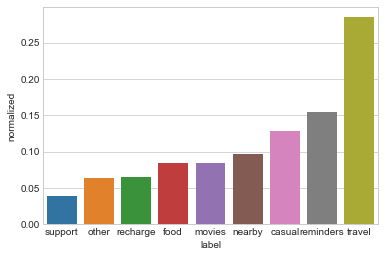

'yhist_plot'  395.74 ms



X_train shape: (40659,)
y_train shape: (40659, 9)
X_test shape: (10000,)
y_test shape: (10000, 9)

In [7]:
x = Haptik('./data')
x.yhist_plot()

## 2.6. `Haptik` Class: Modeling (the dataset)

In [9]:
class Haptik(Haptik):
    
    def label_accuracy(self, y_true, y_pred):
        """Compute label accuracy
        """
        res = (y_true == y_pred)
        return (res).sum().sum()/res.size
    
    @timeit
    def classify(self,
                 model=OneVsRestClassifier(MultinomialNB())):
        """Fit a model to the dataset
        """
        # Clone local copies
        X_train = copy.deepcopy(self.train_dtm)
        X_test = copy.deepcopy(self.test_dtm)
        y_train = copy.deepcopy(self.y_train)
        y_test = copy.deepcopy(self.y_test)
        

        # Fit and predict
        model.fit(X_train, y_train)
        if isinstance(model, GridSearchCV): # assumes GridSearchCV() has been imported
            self.gridsearchcv = copy.deepcopy(model)
            model = copy.deepcopy(model.best_estimator_)
            
        self.y_pred_class = model.predict(X_test)
        self.model = model
        
        # Compute metrics
        self.accuracy_subset = metrics.accuracy_score(y_test, self.y_pred_class)
        self.accuracy_label = self.label_accuracy(y_test, self.y_pred_class)
        self.c_report = metrics.classification_report(y_test, self.y_pred_class)

        return self
    
    def results(self):
        """Print accuracy and other metrics
        """
        print('accuracy_label: ', self.accuracy_label)
        print('accuracy_subset: ', self.accuracy_subset)
        print('classification report: \n', self.c_report)
        return self
    
    def results_cv(self):
        """Print the best models and the details of cv rounds
        """
        print('cv results: \n', pd.DataFrame(self.gridsearchcv.cv_results_))
        print('best parameters: \n', self.gridsearchcv.best_params_)
        return self


In [10]:
class Haptik(Haptik):
    
    def cv_scores(self):
        """Plot mean scores for a particular grid object
        """
        mean_test_scores = self.gridsearchcv.cv_results_['mean_test_score']
        mean_train_scores = self.gridsearchcv.cv_results_['mean_train_score']
        plt.figure(figsize=(10,6))

        param_values =[str(x) for x in self.gridsearchcv.param_grid.values()[0]]
        plt.plot(param_values, mean_train_scores, c='r')
        plt.plot(param_values, mean_test_scores, c='g')
        
        plt.xlabel(self.gridsearchcv.param_grid.keys()[0])
        plt.ylabel('mean scores')
        plt.show()
        
        return self

# 3. Iterations

In [ ]:
x = Haptik('./data').preprocess().vectorize()
pickle_dump(x, '0.pkl')

## 3.1. Iteration 1: Default Values

1. **model** = OneVsRestClassifier(MultinomialNB()), 
2. **vectorizer** = CountVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)
3. **Label Accuracy** = 94.03%
4. **Subset Accuracy** = 63.63%
5. **Time Taken**
    - `preprocess()`: 16042.35ms (16s)
    - `classify()`: 2839.06ms (3s)

In [ ]:
x.classify().results()

In [ ]:
x.wordfreq.shape

## 3.2. Iteration 2: Default Values

1. **model** = OneVsRestClassifier(MultinomialNB()), 
2. **vectorizer** = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)
3. **Label Accuracy** = 
4. **Subset Accuracy** = 

In [ ]:
x.vectorize(vectorizer=TfidfVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=4))
x.classify().results()

## 3.3. Iteration 3: Random Forest

1. **model** =  
2. **vectorizer** = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)
3. **Label Accuracy** = 
4. **Subset Accuracy** = 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from haptik import Haptik, timeit, pickle_dump, pickle_load

x = Haptik('./data')

In [ ]:
x.preprocess()

In [ ]:
x.vectorize()

In [ ]:
x.reduce_dimensions(k=10000)

In [ ]:
x.classify(model=RandomForestClassifier(n_estimators=200, max_depth=2500,
                                        min_samples_split=5, n_jobs=-1,
                                        max_features=0.008, # 0.00735215 = sqrt(18,500)/18,500
                                        random_state=42, verbose=3)).results()

## 3.4. Iteration 4: Random Forest Grid Search

1. **model** =  
2. **vectorizer** = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)
3. **Label Accuracy** = 
4. **Subset Accuracy** = 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
    
param_grid_rf = {"rf__n_estimators": [100, 150, 200, 250, 300, 350, 400],
                  "rf__max_depth": [2000, 2250, 2500, 2750, 3000],
                  "rf__min_samples_split": [4, 5, 6],
                  "rf__max_features": [0.005, 0.006, 0.007, 0.00735215, 0.008, 0.07, 0.2]}

# https://stackoverflow.com/questions/34889110/random-forest-with-gridsearchcv-error-on-param-grid
def rf_search(param_grid):
    rf = RandomForestClassifier(random_state=42)
    pipeline = Pipeline([
        ('rf', rf)
    ])
    grid = GridSearchCV(pipeline, param_grid, n_jobs=-1, verbose=3, cv=3)
    return grid

x = Haptik('./data').preprocess().vectorize().reduce_dimensions()

In [ ]:
x.classify(model=rf_search(param_grid_rf)).results()

In [ ]:
pickle_dump(x, 'rf_1.pkl')

In [ ]:
mod1 = copy.deepcopy(x.model)

## 3.5. Iteration 5: Multinomial NB Grid Search

1. **model** =  
2. **vectorizer** = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)
3. **Label Accuracy** = 
4. **Subset Accuracy** = 

In [ ]:
from sklearn.naive_bayes import MultinomialNB

param_grid = {"estimator__alpha": np.arange(0, 1, 0.05),
              "estimator__fit_prior": [True, False]}

def mnb_search(param_grid):
    nb = OneVsRestClassifier(MultinomialNB())
    grid = GridSearchCV(nb, param_grid, n_jobs=-1, verbose=3)
    return grid

x.classify(model=mnb_search(param_grid))
pickle_dump(x, 'mnb_1.pkl')

In [ ]:
x.results()

In [ ]:
mod2 = copy.deepcopy(x.model)

# Exhaustive Hyperparameter Tuning

**Warning**: Do not try this at home. Do it on the cloud. :)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

param_grid_1 = {"n_estimators": [300, 400, 500, 600, 700, 800]}
param_grid_2 = {"n_estimators": [300],
                "max_depth": [3, 4, 5, 6, 7, 8, 9]}
param_grid_3 = {"n_estimators": [300],
                "max_depth": [3, 7],
                "max_features": [1, 3, 10]}
param_grid_4 = {"n_estimators": [300],
                "max_depth": [3, 7],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 4, 8]}
param_grid_5 = {"n_estimators": [300],
                "max_depth": [3, 7],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 4, 8],
                "min_samples_leaf": [1, 3, 10]}

# https://stackoverflow.com/questions/34889110/random-forest-with-gridsearchcv-error-on-param-grid
def rf_search(param_grid):
    rf = RandomForestClassifier()
    grid = GridSearchCV(rf, param_grid, n_jobs=-1, verbose=3)
    return grid

x = Haptik('./data').preprocess()

x.classify(model=rf_search(param_grid_1)).results()
pickle_dump(x, 'rf_job_1.pkl')

# The Way Forward

* Named Entity Recognition
* Spell Check: People make many typing mistakes or shorten words while typing. Correcting them should help improve the accuracy.

Here are some curated hint you can incorporate in your codebase:

In [2]:
sw_curated = ['a9c0', 'f0af5ee2b89b', '676951', 'hi', '727893', '55616', 'task_nam',
              'user_id', '50', '16', 'exotel','ok', 'haptik', 'nearbi',
              'api_nam', 'offset', 'user_id', '00', 'pleas', 'can', 'pl',
              'drink_water', 'reminer_list', 'trains_api', 'product_id', 
              'I', 'j', 'se', 'sl', '10', 'hai', 'll', 'kya', 'rs', 'sorri',
              'know', '30', 'one', '10 00', 'bu', 'reminder_list',
              'plz', 'everi']

temporal = ['time', 'will', 'today', 'everyday', 'now', 'hour', 'tomorrow', 'day',\
'apr', 'april', 'fri', 'friday', 'june', 'later', 'may', 'min', 'minut',\
'mon', 'month', 'noon', 'nov', 'oct', 'octob', 'sat', 'sep', 'sept', 'sun',\
'sunday', 'thursday', 'tommorow', 'wed', 'wednesday', 'week', 'weekend', 'yesterday', 'hr']

misc = ['alreadi', 'also', 'around', 'ca', 'do', 'done', 'dont', 'iam', 'im', 'in',\
'it', 'just', 'let', 'much', 'name', 'oh', 'ok', 'okay', 'shall', 'sure', 'th',\
'that', 'to', 'wat', 'wil', 'yet', 'near', 'abt', 'didnt', 'fr', 'kk', 'll', 'nd', 'ohk']

pleasantries = ['thank', 'hello', 'hi', 'hii', 'thanku', 'thnk', 'thnx', 'thx']

address = ['bro', 'dr', 'dude', 'mam', 'miss', 'mr', 'sir']

hindi = ['abhi', 'bhai', 'ho', 'hu', 'ji', 'ka', 'ke', 'ki', 'ko']

numeric = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', \
'ten', 'Eleven', 'Twelve', 'Thirteen', 'Fourteen', 'Fifteen', 'Sixteen', 'Seventeen', \
'Eighteen', 'Nineteen', 'Twenty', 'Twenty-one', 'Twenty-two', 'Twenty-three', \
'Twenty-four', 'Twenty-five', 'Twenty-six', 'Twenty-seven', 'Twenty-eight', \
'Twenty-nine', 'Thirty', 'Thirty-one']

ordinal = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eight', 'ninth', \
'tenth', 'eleventh', 'twelfth', 'thirteenth', 'fourteenth', 'fifteenth', 'sixteenth', \
'seventeenth', 'eighteenth', 'nineteenth', 'twentieth', 'twenty-first', 'twenty-second', \
'twenty-third', 'twenty-fourth', 'twenty-fifth', \
'twenty-sixth', 'twenty-seventh', 'twenty eighth', 'twenty-ninth', 'thirtieth', 'thirty-first']


In [3]:
x.preprocess(stop_lists=[sw_curated, temporal, misc, pleasantries, address, hindi])

0                                                    [7am]
1                                           [chocol, cake]
2              [close, mortic, tenon, joint, door, diment]
3                                  [train, eppo, kelambum]
4                                 [cancel, flight, ticket]
5                                       [chamg, 12pm, 9pm]
6                                    [want, go, rajasthan]
7                                                   [room]
8                                 [arrang, flight, ticket]
9                                           [kind, remind]
10                                 [jamshedpur, jharkhand]
11                                     [noidaa, secot, 44]
12                                      [flight, spicejet]
13                                                  [uber]
14                                                [3.3.17]
15                                            [fare, high]
16                             [train, run, jalgaon, pun


X_train shape: (40659,)
y_train shape: (40659, 9)
X_test shape: (10000,)
y_test shape: (10000, 9)

In [4]:
x.vectorize()

'vectorize'  2320.87 ms



X_train shape: (40659,)
y_train shape: (40659, 9)
X_test shape: (10000,)
y_test shape: (10000, 9)

In [5]:
# pd.set_option("display.max_rows", 600)
# x.wordfreq.to_csv("wordfreq.csv", encoding='utf-8')

In [6]:
x.reduce_dimensions(k=10000)

'reduce_dimensions'  69.63 ms



X_train shape: (40659,)
y_train shape: (40659, 9)
X_test shape: (10000,)
y_test shape: (10000, 9)

In [7]:
x.classify(model=RandomForestClassifier(n_estimators=200, max_depth=2500,
                                        min_samples_split=5, n_jobs=-1,
                                        max_features=0.008, # 0.00735215 = sqrt(18,500)/18,500
                                        random_state=42, verbose=0)).results()

'classify'  157714.21 ms
accuracy_label:  0.945844444444
accuracy_subset:  0.734
classification report: 
              precision    recall  f1-score   support

          0       0.81      0.60      0.69       810
          1       0.77      0.70      0.74       450
          2       0.69      0.29      0.41       371
          3       0.87      0.84      0.85       893
          4       0.80      0.85      0.83      2138
          5       0.69      0.61      0.65       807
          6       0.75      0.62      0.68       637
          7       0.83      0.84      0.84      3282
          8       0.92      0.51      0.65      1668

avg / total       0.82      0.72      0.76     11056




X_train shape: (40659,)
y_train shape: (40659, 9)
X_test shape: (10000,)
y_test shape: (10000, 9)